# Финансовая аналитика

Оконные функции часто используют в продуктовой и финансовой аналитике. Поэтому на этом уроке порешаем задачки, связанные с продажами и тарифами.

### Исходные данные

Предположим, у вас есть облачный сервис. Вы продаете подписки на тарифные планы silver, gold и platinum. Таблица `sales` содержит агрегированные данные о продажах по каждому тарифу за месяц:

In [ ]:
SELECT * 
  FROM sales 
 LIMIT 10

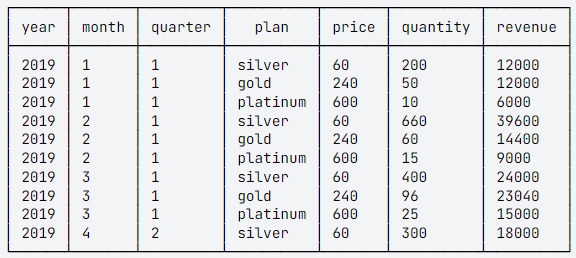

- year, month, quarter — год, месяц и квартал продажи;
- plan — тарифный план;
- price — стоимость одной подписки;
- quantity — количество проданных подписок по данному тарифу за месяц;
- revenue = price * quantity

Таблица `sales` содержит продажи за 2019 и 2020 годы.

### 34 Выручка по тарифу gold за 2020

Есть таблица продаж `sales`. Посчитайте выручку для тарифа gold по месяцам 2020 года.

Для каждого месяца дополнительно укажите:

- выручку за предыдущий месяц (prev);
- процент, который составляет выручка текущего месяца от prev (perc).

Процент округлите до целого.

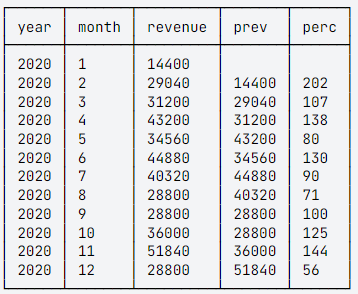

Сортировка результата: month

Пустые поля prev и perc — это null.

In [ ]:
SELECT year, 
       month, 
       revenue,
       LAG(revenue) OVER w AS prev,
       ROUND(revenue * 100.0 / LAG(revenue) OVER w) AS perc
  FROM sales
 WHERE plan = 'gold' AND year = 2020
WINDOW w AS (ORDER BY month)
 ORDER BY month

### 35 Выручка по тарифам за 1 квартал 2020

Есть таблица продаж `sales`. Посчитайте выручку нарастающим итогом по каждому тарифному плану за первые три месяца 2020 года.

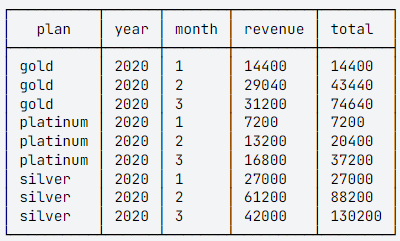

Сортировка результата: plan, month

In [ ]:
SELECT plan, 
       year, 
       month, 
       revenue, 
       SUM(revenue) OVER w AS total
  FROM sales
 WHERE year = 2020 AND quarter = 1
WINDOW w AS (PARTITION BY plan
             ORDER BY month)
 ORDER BY plan, month

### 36 Скользящее среднее по тарифу platinum за 2020

Есть таблица продаж `sales`. Посчитайте скользящую среднюю выручку за 3 месяца для тарифа platinum в 2020 году.

Округлите среднюю выручку до целого.

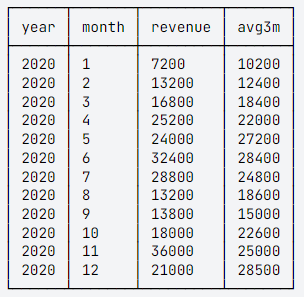

Сортировка результата: month

In [ ]:
SELECT year, 
       month, 
       revenue,
       ROUND(AVG(revenue) OVER w) AS avg3m
  FROM sales
 WHERE plan = 'platinum' AND year = 2020
WINDOW w AS (ORDER BY month
             ROWS BETWEEN 1 PRECEDING AND 1 FOLLOWING)
 ORDER BY month

### 37 Сравнение с декабрем

Есть таблица продаж `sales`. Посчитайте выручку по месяцам для тарифа silver.

Для каждого месяца дополнительно укажите:

- выручку за декабрь этого же года (december);  
- процент, который составляет выручка текущего месяца от december (perc).  

Процент округлите до целого.

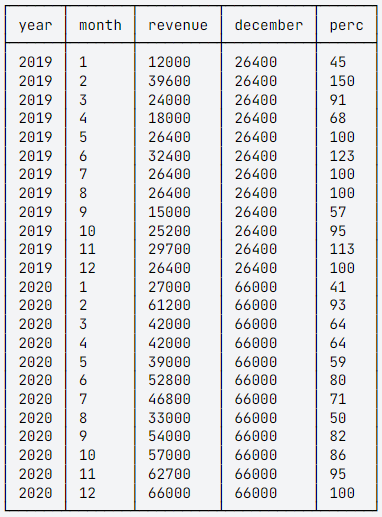

Сортировка результата: year, month

In [ ]:
SELECT year, 
       month, 
       revenue,
       LAST_VALUE(revenue) OVER w AS december,
       ROUND(revenue * 100.0 / LAST_VALUE(revenue) OVER w) AS perc
  FROM sales
 WHERE plan = 'silver'
WINDOW w AS (PARTITION BY year
             ORDER BY month
             ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING)
 ORDER BY year, month

### 38 Вклад тарифов

Есть таблица продаж `sales`. Посчитайте, какой вклад (в процентах) внес каждый из тарифов в общую выручку за год.  

Процент округлите до целого.

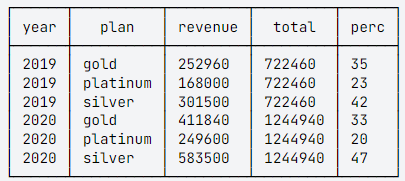

Сортировка результата: year, plan

In [ ]:
WITH data AS (
SELECT year, 
       plan, 
       SUM(revenue) AS revenue
  FROM sales
 GROUP BY year, plan
)

SELECT year, 
       plan, 
       revenue,
       SUM(revenue) OVER w AS total,
       ROUND(100 * revenue / SUM(revenue) OVER w) AS perc
  FROM data
WINDOW w AS (PARTITION BY year)
 ORDER BY year, plan

### 39 Высокая, средняя и низкая выручка

Есть таблица продаж sales. Разбейте месяцы 2020 года на три группы по выручке:  

- tile = 1 — высокая,  
- tile = 2 — средняя,  
- tile = 3 — низкая.

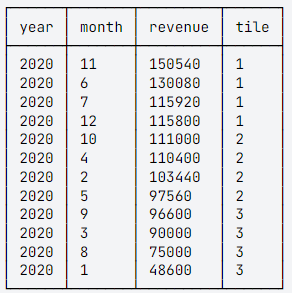

Сортировка результата: revenue desc

In [ ]:
WITH data AS (
SELECT year, 
       month,
       SUM(revenue) AS revenue
  FROM sales
 WHERE year = 2020
 GROUP BY year, month
)

SELECT year, 
       month, 
       revenue,
       NTILE(3) OVER w AS tile
  FROM data
WINDOW w AS (ORDER BY revenue DESC)
 ORDER BY revenue DESC, month

### 40 2020 vs 2019

Есть таблица продаж `sales`. Посчитайте выручку по кварталам 2020 года.

Для каждого квартала дополнительно укажите:

- выручку за аналогичный квартал 2019 года (prev);  
- процент, который составляет выручка текущего квартала от prev (perc).

Процент округлите до целого.

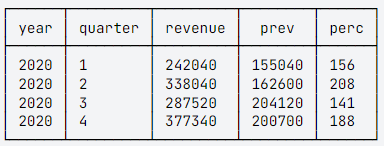

Сортировка результата: quarter

In [ ]:
WITH data AS (
SELECT year, 
       quarter,
       SUM(revenue) AS revenue,
       LAG(SUM(revenue), 4) OVER w AS prev,
       ROUND(SUM(revenue) * 100.0 / LAG(SUM(revenue), 4) OVER ()) AS perc
  FROM sales
 GROUP BY year, quarter
window w AS (
 ORDER BY year, quarter
  )
)

SELECT year, 
       quarter, 
       revenue,
       prev, 
       perc
  FROM data
 WHERE year = 2020
 ORDER BY quarter

### 41 Рейтинг месяцев по количеству продаж в 2020

Рейтинг месяцев по количеству продаж в 2020

Есть таблица продаж `sales`. Составьте рейтинг месяцев 2020 года с точки зрения количества продаж (quantity) по каждому из тарифов. Чем больше подписок тарифа P было продано в месяц M, тем выше место M в рейтинге по тарифу P:

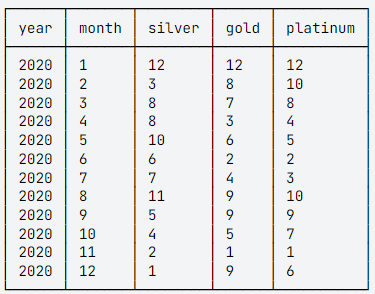

Например, в декабре было продано больше подписок silver, чем в любой другой месяц (1-е место в столбце silver). Для тарифа gold декабрь на 9-м месте, для platinum — на 6-м. Январь же оказался самым слабым месяцем для всех трех тарифов.

Сортировка результата: month

In [ ]:
WITH data AS (
SELECT year, 
       month, 
       plan, 
       quantity,
       RANK() OVER w AS qrank
  FROM sales
 WHERE year = 2020
window w AS (PARTITION BY plan
             ORDER BY quantity DESC
  )
)

SELECT year, 
       month,
       SUM(CASE WHEN plan = 'silver' THEN qrank ELSE 0 END) AS silver,
       SUM(CASE WHEN plan = 'gold' THEN qrank ELSE 0 END) AS gold,
       SUM(CASE WHEN plan = 'platinum' THEN qrank ELSE 0 END) AS platinum
  FROM data
 GROUP BY year, month
 ORDER BY month